In [1]:
import sys
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/lartpc_mlreco3d")   # locally
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/pi0_reco")          # locally
#sys.path.append("/u/nu/rberner/pi0_reconstruction/lartpc_mlreco3d")                             # nu-gpu0x
#sys.path.append("/u/nu/rberner/pi0_reconstruction/pi0_reco")                                    # nu-gpu0x
sys.path.append("../../lartpc_mlreco3d")                                                         # JupyterLab
sys.path.append("../../pi0_reco")                                                                # JupyterLab

In [2]:
# I/O config
import yaml
io_cfg = """
iotool:
  batch_size: 1
  shuffle: False
  num_workers: 1
  collate_fn: CollateSparse
  #sampler:
  #  name: RandomSequenceSampler
  dataset:
    name: LArCVDataset
    data_keys:
     #- /home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/data/train.root       # locally
     #- /u/nu/rberner/pi0_reconstruction/data/train.root                                 # nu-gpu0x
     - ../../data/train.root                                                             # JupyterLab 
    limit_num_files: 1
    schema:
      input_data:
        - parse_sparse3d_scn
        - sparse3d_pcluster
      segment_label:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      semantics:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      dbscan_label:
        - parse_cluster3d_clean_full
        - cluster3d_pcluster
        - particle_corrected
        - sparse3d_pcluster_semantics
      particles_label:
        - parse_particle_points
        - sparse3d_pcluster
        - particle_corrected
      cluster_label:
        - parse_cluster3d_full
        - cluster3d_pcluster
        - particle_corrected
      particles:
        - parse_particle_asis
        - particle_corrected
        - cluster3d_pcluster
      ppn_label:
        - parse_particle_points
        - sparse3d_pcluster
        - particle_corrected
"""

In [3]:
# Configuration of the reconstruction chain
chain_cfg = '''
name: pi0_chain_fiducialized
#net_cfg: /home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/config_files/uresnet_ppn.cfg                      # locally
#net_cfg: /home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/config_files/train_cluster_chain_gnn_dbscan.cfg   # locally
#net_cfg: /u/nu/rberner/pi0_reconstruction/config_files/uresnet_ppn_gpu0.cfg                                           # nu-gpu0x
#net_cfg: /u/nu/rberner/pi0_reconstruction/config_files/fullChain_gnn_dbscan_gpu0.cfg                                  # nu-gpu0x
net_cfg: ../../config_files/fullChain_gnn_dbscan_gpu0.cfg                                                              # JupyterLab
segment:               label      # label, uresnet
deghost:                          # label, uresnet
charge2energy:                    # null, constant, average(, full, enet)
charge2energy_cst:     0.0082     # energy response constant (0.0082 for mask, 0.0052 for uresnet)
charge2energy_average: 0.877      # energy response average (1.3693 for mask, 0.877 for uresnet)
shower_start:          ppn        # label, ppn, gnn
shower_fragment:       dbscan     # label, dbscan
shower_direction:      pca        # label, pca, cent
shower_cluster:        cone       # label, cone, gnn
shower_cluster_params:
  IP: 40
  Distance: 300
shower_energy:         pixel_sum  # label, pixel_sum
shower_match:          proximity  # label, proximity
refit_dir:             true       # true, false
refit_cone:            true       # true, false
fiducialize:           14         # Number of pixels to be removed from edge of LAr volume (pixel pitch: 3mm)
'''
chain_cfg = yaml.load(chain_cfg,Loader=yaml.Loader)

In [4]:
# Progress bar
from IPython.display import HTML, display
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [5]:
class Results(object):
    '''
    Class for the storage of result acquired during chain.run_loop() process.
    The attributes are added in a dynamic way.
    This class can be used as:
    res = Results()
    res.attribute = someobject
    Use Results.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    ev_id

    true_n_pi0s
    true_n_gammas
    true_pi0_track_ids
    true_gamma_particle_ids
    true_gamma_group_ids
    true_gamma_mom
    true_gamma_dir
    true_gamma_first_step
    true_gamma_pos
    true_gamma_ekin
    true_gamma_edep
    true_gamma_voxels
    true_gamma_n_voxels
    true_OOFV                   # If at least one edep is at boundary pixels -> store shower_number in this list
    true_gamma_angle
    true_pi0_mass

    reco_n_pi0
    reco_n_gammas
    reco_matches
    reco_gamma_mom
    reco_gamma_dir
    reco_gamma_start
    reco_gamma_edep
    reco_gamma_pid
    reco_gamma_voxels_mask      # array of n lists (n=number of reco showers) which contain voxel_mask indices
    reco_gamma_n_voxels_mask    # length of gamma_voxels_mask
    reco_gamma_voxels           # array of n lists (n=number of reco showers) which contain voxel coordinates
    reco_gamma_n_voxels         # length of gamma_voxels
    reco_OOFV                   # If at least one edep is at boundary pixels -> store shower_number in this list
    reco_gamma_angle
    reco_pi0_mass
    '''
    
    pass

In [6]:
# Some imports
from larcv import larcv
import numpy as np
from numpy import linalg

Welcome to JupyROOT 6.16/00


In [7]:
# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(io_cfg, chain_cfg)

# Define a list with the results obtained by run_loop()
ResultsList = []

# Loop over dataset
data_size = 20 #len(chain.hs.data_io)
out       = display(progress(0,data_size,'images'),display_id=True)

for event in range(data_size):
    #print('Event: ', event)
    
    chain.run_loop()
    
    '''
    try:
        chain.run_loop()
    except RuntimeError:
        print('RuntimeError in event ', event)
        continue
    except ValueError:
        print('ValueError in event ', event)
        continue
    except IndexError:
        print('IndexError in event ', event)
        continue
    except TypeError:
        print('TypeError in event ', event)
        continue
    '''


    # Instantiate Results class
    extracted_data = Results()


    # Add members of the Results class
    extracted_data.event_id                    = chain.true_info['ev_id']
    assert chain.true_info['ev_id']            == chain.event['index']

    extracted_data.true_n_pi0s                 = chain.true_info['n_pi0']
    extracted_data.true_n_gammas               = chain.true_info['n_gammas']
    extracted_data.true_pi0_track_ids          = chain.true_info['pi0_track_ids']
    extracted_data.true_gamma_particle_ids     = chain.true_info['gamma_particle_ids']
    extracted_data.true_gamma_group_ids        = chain.true_info['gamma_group_ids']
    extracted_data.true_gamma_mom              = chain.true_info['gamma_mom']
    extracted_data.true_gamma_dir              = chain.true_info['gamma_dir']
    extracted_data.true_gamma_first_step       = chain.true_info['gamma_first_step']
    extracted_data.true_gamma_pos              = chain.true_info['gamma_pos']
    extracted_data.true_gamma_ekin             = chain.true_info['gamma_ekin']
    extracted_data.true_gamma_edep             = chain.true_info['gamma_edep']
    extracted_data.true_gamma_voxels           = chain.true_info['gamma_voxels']
    extracted_data.true_gamma_n_voxels         = chain.true_info['gamma_n_voxels']
    extracted_data.true_OOFV                   = chain.true_info['OOFV']
    extracted_data.true_gamma_angle            = chain.true_info['gamma_angle']
    extracted_data.true_pi0_mass               = chain.true_info['pi0_mass']

    extracted_data.reco_n_pi0s                 = chain.reco_info['n_pi0']
    extracted_data.reco_n_gammas               = chain.reco_info['n_gammas']
    extracted_data.reco_matches                = chain.reco_info['matches']
    extracted_data.reco_gamma_mom              = chain.reco_info['gamma_mom']
    extracted_data.reco_gamma_dir              = chain.reco_info['gamma_dir']
    extracted_data.reco_gamma_start            = chain.reco_info['gamma_start']
    extracted_data.reco_gamma_edep             = chain.reco_info['gamma_edep']
    extracted_data.reco_gamma_pid              = chain.reco_info['gamma_pid']
    extracted_data.reco_gamma_voxels_mask      = chain.reco_info['gamma_voxels_mask']
    extracted_data.reco_gamma_n_voxels_mask    = chain.reco_info['gamma_n_voxels_mask']
    extracted_data.reco_gamma_voxels           = chain.reco_info['gamma_voxels']
    extracted_data.reco_gamma_n_voxels         = chain.reco_info['gamma_n_voxels']
    extracted_data.reco_OOFV                   = chain.reco_info['OOFV']
    extracted_data.reco_gamma_angle            = chain.reco_info['gamma_angle']
    extracted_data.reco_pi0_mass               = chain.reco_info['pi0_mass']


    # Print to screen
    print_information = False
    if print_information:
        print(' event_id: \t ',    extracted_data.event_id)
        print(' true_n_pi0s: \t ', extracted_data.true_n_pi0s)
        print(' reco_n_pi0s: \t ', extracted_data.reco_n_pi0s)
        print(' ------------------------------------------------------ ')


    # Append the extracted data to the ResultsList
    ResultsList.append(extracted_data)
    

    '''
    # Draw the last event if requested
    #i_draw    = 0
    #n_draw    = 0
    #if 'matches' in chain.output and len(chain.output['matches']) and i_draw < n_draw:
    #    chain.draw()
    #    i_draw += 1
    #chain.draw()
    draw_events = []
    if chain.true_info['ev_id'] in draw_events:
        chain.draw()
    '''


    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))

Initialized Pi0 mass chain, log path: masses_fiducialized_14px.csv

Config processed at: Linux slac-larcv2-rberner-20200403.0 3.10.0-1062.4.1.el7.x86_64 #1 SMP Fri Oct 18 17:15:30 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': ['../../data/train.root'],
                                 'limit_num_files': 1,
                                 'name': 'LArCVDataset',
                                 'schema': {   'cluster_label': [   'parse_cluster3d_full',
                                                                    'cluster3d_pcluster',
                                                                    'particle_corrected'],
                                               'dbscan_label': [   'parse_cluster3d_clean_full',
                                                                   'cluster3d_pcluster',
                        

# Event Selection

In [8]:
# Define which cuts to apply:
# -------------------------------------------------------
# Cuts for events:
apply_at_least_1_reco_pi0             = False      # skip event
apply_at_least_1_true_pi0             = False      # skip event
apply_n_true_pi0_equal_n_reco_pi0     = False      # skip event

# Cuts for single pi0s in the event
apply_true_OOVF                       = True      # skip true pi0 if >1 edeps of its gammas are OOFV
apply_reco_OOVF                       = True      # skip reco pi0 if >1 edeps of its gammas are OOFV
apply_threshold_reco_edep, min_edep   = True, 20   # skip reco pi0 if one of the gammas has reco energy < min_edep MeV

# Define lists for the event selection
selected_events             = [] # list with the event_ids which passed the event cuts
selected_true_gamma_indices = [] # will be filled with an array for every event. The array stores the gamma indices of gammas passed the selection
selected_reco_gamma_indices = [] # will be filled with an array for every event. The array stores the gamma indices of gammas passed the selection
masses                      = [] # to store the reconstructed pi0 mass for candidates which passed the selection


# Access the data stored in ResultsList
for i, res in enumerate(ResultsList):
    
    # Make array with all gamma_indices in the event
    # -> In the selection process, we will remove an index if the corresponding gamma fails a cut
    true_gamma_indices = [int(i) for i in range(int(res.true_n_gammas))]
    reco_gamma_indices = [int(i) for i in range(int(res.reco_n_gammas))]



    # Skip if not at least 1 reco pi0
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++
    if apply_at_least_1_reco_pi0:
        if res.reco_n_pi0s < 1:
            continue

    # Skip if not at least 1 true pi0
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++
    if apply_at_least_1_true_pi0:
        if res.true_n_pi0s < 1:
            continue

    # Skip if not reco_n_pi0s == true_n_pi0s
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++
    if apply_n_true_pi0_equal_n_reco_pi0:
        if res.true_n_pi0s != res.reco_n_pi0s:
            continue

    # Append the event_id to the list of selected events
    selected_events.append(i)



    # Cuts on true pi0s
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Remove indices from true_gamma_indices which do not pass cuts:
    for true_gamma in range(int(res.true_n_gammas)):
        # OOFV:
        if apply_true_OOVF:
            if true_gamma in res.true_OOFV:
                true_gamma_indices.remove(true_gamma)


    # Cuts on reco pi0s
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Remove indices from reco_gamma_indices which do not pass cuts:
    for reco_gamma in range(int(res.reco_n_gammas)):
        # OOFV:
        if apply_reco_OOVF:
            if reco_gamma in res.reco_OOFV:
                reco_gamma_indices.remove(reco_gamma)
                continue
        # Cut on reconstructed gamma energy:
        if apply_threshold_reco_edep:
            min_edep = 20
            if (res.reco_gamma_edep)[reco_gamma] < min_edep:
                reco_gamma_indices.remove(reco_gamma)
                continue




    # Append the arrays with gamma_indices to the list of selected events
    selected_true_gamma_indices.append(true_gamma_indices)
    selected_reco_gamma_indices.append(reco_gamma_indices)
    
    # TODO: APPEND NOT ARRAYS BUT THE LISTS!
    # E.G.:
    #for index in range(len(selected_reco_gamma_indices[i])):
    #    reco_list.append(selected_reco_gamma_indices[i][index])
    

# Print to Screen for debuging

In [9]:
print_informations = False

if print_informations:
    for i, res in enumerate(ResultsList):
        if res.event_id in selected_events:
            print(' ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ ')
            print(' event_id: ', res.event_id)
            print(' - - - - - - - - - ')
            print(' n true pi0s: ', res.true_n_pi0s)
            print(' n reco pi0s: ', res.reco_n_pi0s)
            print(' - - - - - - - - - ')
            
            true_list = []
            for index in range(len(selected_true_gamma_indices[i])):
                true_list.append(selected_true_gamma_indices[i][index])
            for true_pi0 in range(res.true_n_pi0s):
                #print(' selected true gamma indices: ', selected_true_gamma_indices[i])
                #print(' 2*true_pi0: ', 2*true_pi0)
                #print(' 2*true_pi0+1: ', 2*true_pi0+1)
                #print(' true_list: ', true_list)
                print(' pi0', true_pi0, ' \t true gamma OOFV: \t ',        (res.true_OOFV))
                print(' pi0', true_pi0, ' \t true gamma angle [rad]: ',    (res.true_gamma_angle)[2*true_pi0])
                if 2*true_pi0 in true_list and 2*true_pi0+1 in true_list:
                    print(' TRUE: THIS ONE GOT ACCEPTED! ')
                    #print(' pi0', true_pi0, ' \t true gamma 1 mom: \t ',     (res.true_gamma_mom)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 mom: \t ',     (res.true_gamma_mom)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma 1 dir: \t ',     (res.true_gamma_dir)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 dir: \t ',     (res.true_gamma_dir)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma 1 1st_step:\t ', (res.true_gamma_first_step)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 1st_step:\t ', (res.true_gamma_first_step)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma 1 pos: \t ',     (res.true_gamma_pos)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 pos: \t ',     (res.true_gamma_pos)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma 1 ekin: \t ',    (res.true_gamma_ekin)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 ekin: \t ',      (res.true_gamma_ekin)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma 1 edep: \t ',      (res.true_gamma_edep)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 edep: \t ',      (res.true_gamma_edep)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma voxels: \t ',      (res.true_gamma_voxels))
                    #print(' pi0', true_pi0, ' \t true gamma 1 n vox: \t ',     (res.true_gamma_n_voxels)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true gamma 2 n vox: \t ',     (res.true_gamma_n_voxels)[2*true_pi0+1])
                    #print(' pi0', true_pi0, ' \t true gamma OOFV: \t ',        (res.true_OOFV))
                    #print(' pi0', true_pi0, ' \t true gamma angle [rad]: ',    (res.true_gamma_angle)[2*true_pi0])
                    #print(' pi0', true_pi0, ' \t true pi0 mass: \t ',          (res.true_pi0_mass)[2*true_pi0])
                print(' - - - - - - - - - ')

                    
            reco_list = []
            for index in range(len(selected_reco_gamma_indices[i])):
                reco_list.append(selected_reco_gamma_indices[i][index])
            for reco_pi0 in range(res.reco_n_pi0s):
                #print(' selected reco gamma indices: ', selected_reco_gamma_indices[i])
                #print(' 2*reco_pi0: ', 2*reco_pi0)
                #print(' 2*reco_pi0+1: ', 2*reco_pi0+1)
                #print(' reco_list: ', reco_list)
                print(' pi0', reco_pi0, ' \t reco gamma 1 edep: \t ',      (res.reco_gamma_edep)[2*reco_pi0])
                print(' pi0', reco_pi0, ' \t reco gamma 2 edep: \t ',      (res.reco_gamma_edep)[2*reco_pi0+1])
                print(' pi0', reco_pi0, ' \t reco gamma OOFV: \t ',        (res.reco_OOFV))
                print(' pi0', reco_pi0, ' \t reco gamma angle [rad]: ',    (res.reco_gamma_angle)[reco_pi0])
                print(' pi0', reco_pi0, ' \t reco pi0 mass: \t ',          (res.reco_pi0_mass)[reco_pi0])
                
                if 2*reco_pi0 in reco_list and 2*reco_pi0+1 in reco_list:
                    print(' TRUE: THIS ONE GOT ACCEPTED! ')
                    #print(' pi0', reco_pi0, ' \t reco gamma 1 mom: \t ',       (res.reco_gamma_mom)[2*reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco gamma 2 mom: \t ',       (res.reco_gamma_mom)[2*reco_pi0+1])
                    #print(' pi0', reco_pi0, ' \t reco gamma 1 dir: \t ',       (res.reco_gamma_dir)[2*reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco gamma 2 dir: \t ',       (res.reco_gamma_dir)[2*reco_pi0+1])
                    #print(' pi0', reco_pi0, ' \t reco gamma 1 start: \t ',     (res.reco_gamma_start)[2*reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco gamma 2 start: \t ',     (res.reco_gamma_start)[2*reco_pi0+1])
                    #print(' pi0', reco_pi0, ' \t reco gamma 1 edep: \t ',      (res.reco_gamma_edep)[2*reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco gamma 2 edep: \t ',      (res.reco_gamma_edep)[2*reco_pi0+1])
                    #print(' pi0', reco_pi0, ' \t true gamma voxels: \t ',      (res.reco_gamma_voxels)[1])
                    #print(' pi0', reco_pi0, ' \t true gamma voxels: \t ',      (res.reco_gamma_voxels)[2])
                    #print(' pi0', reco_pi0, ' \t true gamma voxels: \t ',      (res.reco_gamma_voxels)[3])
                    #print(' pi0', reco_pi0, ' \t reco gamma 1 n vox: \t ',     (res.reco_gamma_n_voxels)[2*reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco gamma 2 n vox: \t ',     (res.reco_gamma_n_voxels)[2*reco_pi0+1])
                    #print(' pi0', reco_pi0, ' \t reco gamma OOFV: \t ',        (res.reco_OOFV))
                    #print(' pi0', reco_pi0, ' \t reco gamma angle [rad]: ',    (res.reco_gamma_angle)[reco_pi0])
                    #print(' pi0', reco_pi0, ' \t reco pi0 mass: \t ',          (res.reco_pi0_mass)[reco_pi0])
                print(' - - - - - - - - - ')

In [10]:
#masses = [] # to store the reconstructed pi0 mass for candidates which passed the selection

#for i, res in enumerate(ResultsList):
#    if res.event_id in selected_events:
#        reco_list = []
#        for index in range(len(selected_reco_gamma_indices[i])):
#            reco_list.append(selected_reco_gamma_indices[i][index])
#        for reco_pi0 in range(res.reco_n_pi0s):
#            if 2*reco_pi0 in reco_list and 2*reco_pi0+1 in reco_list:
#                    masses.append(res.reco_pi0_mass[reco_pi0])

# Plot Masses of Selected Events

 Fitted parameters: 
 a [-]: 	  4.3277899066361276e-15  
 μ [MeV/c2]: 	  100.0  
 σ [MeV/c2]: 	  10.000000005886081


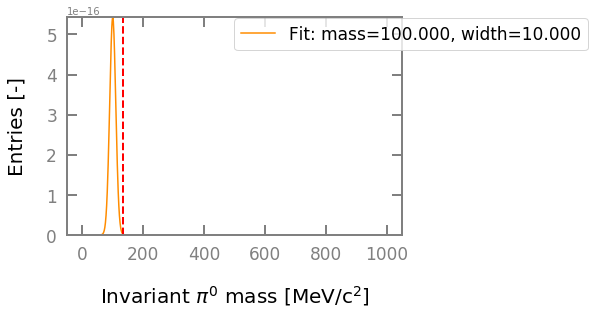

In [11]:
from matplotlib import pyplot as plt


# Define fit function
def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma
def fit_func(bins, n, func):
    from scipy.optimize import curve_fit
    center = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(func, center, n, p0=(100, 100, 10))
    print(" Fitted parameters: \n a [-]: \t ", popt[0],
          " \n \u03BC [MeV/c2]: \t ", popt[1],
          " \n \u03C3 [MeV/c2]: \t ", popt[2])
    x = np.arange(0, 300, 1)
    y = func(x, popt[0], popt[1], popt[2])
    plt.plot(x, y, label='Fit: mass=%5.3f, width=%5.3f' % (popt[1], popt[2]), color='darkorange')
    plt.legend(loc=[0.5,0.85], prop={'size': 17})

    
# Define histogram range and binning
x_min    = 0
x_max    = 1000
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)


# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


# Plot masses
n, bins, patches = plt.hist(masses, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='b', linewidth=3, alpha=0.8)
#n_0, bins_0, patches_0 = plt.hist(masses, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='y', linewidth=3, alpha=0.8)
#n_30, bins_30, patches_30 = plt.hist(masses_30, bins=n_bins_x, range=[x_min,x_max], histtype='step', color='g', linewidth=3, alpha=0.8)
#n_50, bins_50, patches_50 = plt.hist(masses_50, bins=n_bins_x, range=[x_min,x_max], histtype='step', color='r', linewidth=3, alpha=0.8)


# Legend
#unfiducialized = 'not fiducialized'
#entry_0 = 'masses_0'
#entry_30 = 'masses_30'
#entry_50 = 'masses_50'
#plt.legend([entry_0, entry_30, entry_50], loc=[0.5,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('Invariant $\pi^0$ mass [MeV/c$^2$]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)


fit_func(bins, n, gaus)
plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2)


# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
#fig_name = 'if_n_TRUEpi0s_equals_n_MATCHEDpi0s.png'
#plt.savefig(fig_name, dpi=400)
#plt.show()

# Calculate True/Reco Shower Overlaps

In [12]:
# Calculate edep overlap reco-true:
import math

distances = [[] for _ in range(2)]
overlaps  = [[] for _ in range(2)] # Note: At the moment: overlaps only of the best gamma pair! TODO: Generalize for all gamma pairs
angles    = [[] for _ in range(2)]

for i, res in enumerate(ResultsList):
    if res.event_id in selected_events:
        
        # If no true or reco pi0 available: skip event
        if res.reco_n_pi0s == 0 or res.true_n_pi0s == 0:
            continue
        
        # Create list of n lists (n=reco_n_pi0s) with voxel IDs of each reco shower
        reco_voxel_ids = [[] for _ in range(2*res.reco_n_pi0s)]
        for reco_gamma in range(2*res.reco_n_pi0s):
            for voxel in range(res.reco_gamma_n_voxels[reco_gamma]):
                index = res.reco_gamma_voxels[reco_gamma][voxel][0] * 1e6 + res.reco_gamma_voxels[reco_gamma][voxel][1] * 1e3 + res.reco_gamma_voxels[reco_gamma][voxel][2]
                reco_voxel_ids[reco_gamma].append(index)
        #print(reco_voxel_ids[0])

        # Create list of n lists (n=true_n_pi0s) with voxel IDs of each true shower
        true_voxel_ids = [[] for _ in range(2*res.true_n_pi0s)]
        for true_gamma in range(2*res.true_n_pi0s):
            for voxel in range(res.true_gamma_n_voxels[true_gamma]):
                index = res.true_gamma_voxels[true_gamma][voxel][0] * 1e6 + res.true_gamma_voxels[true_gamma][voxel][1] * 1e3 + res.true_gamma_voxels[true_gamma][voxel][2]
                true_voxel_ids[true_gamma].append(index)
        #print(true_voxel_ids[0])
        
        # Calculate overlaps:
        reco_overlap_mat = np.zeros([2*res.reco_n_pi0s, 2*res.true_n_pi0s]) # calculates the fraction: n_overlapping_edeps / n_reco_edeps
        true_overlap_mat = np.zeros([2*res.reco_n_pi0s, 2*res.true_n_pi0s]) # calculates the fraction: n_overlapping_edeps / n_true_edeps
        overlap_mat = np.zeros([2*res.reco_n_pi0s, 2*res.true_n_pi0s])      # index-wise multiplication of reco- & true- overlap_mat
        # Note: columns = number of reco_gammas, rows = number of true_gammas
        
        for reco_gamma in range(2*res.reco_n_pi0s):
            for true_gamma in range(2*res.true_n_pi0s):
                counter = 0
                reco_voxels_tot = len(reco_voxel_ids[reco_gamma])
                true_voxels_tot = len(true_voxel_ids[true_gamma])
                for index, reco_ID in enumerate(reco_voxel_ids[reco_gamma]):
                    if reco_ID in true_voxel_ids[true_gamma]:
                        counter += 1
                if reco_voxels_tot != 0 and true_voxels_tot != 0:
                    reco_overlap_mat[reco_gamma][true_gamma] = counter/reco_voxels_tot
                    true_overlap_mat[reco_gamma][true_gamma] = counter/true_voxels_tot
                    overlap_mat[reco_gamma][true_gamma]      = counter/reco_voxels_tot * counter/true_voxels_tot
                else:
                    reco_overlap_mat[reco_gamma][true_gamma] = 0
                    true_overlap_mat[reco_gamma][true_gamma] = 0
                    overlap_mat[reco_gamma][true_gamma]      = 0
        '''         
        print(' reco_overlap_mat: ')
        print(reco_overlap_mat)
        print(' true_overlap_mat: ')
        print(true_overlap_mat)
        '''
        #print(' overlap_mat: ')
        #print(overlap_mat)
        
        
        # For every true pi0: get the gamma-pair which has the largest overlap
        # At this moment: Take the largest number of the matrix for the first pair, then the second largest, etc.
        # TODO: Generalize for > 1 true and reco pi0 (set used blocks in matrix 0 and continue as long as entries > 0 exist?)
        max_index = np.argwhere(overlap_mat.max() == overlap_mat)
        #print(max_index)
        
        reco_gamma_1 = max_index[0][0]
        if((max_index[0][0])%2==1):
            reco_gamma_2 = max_index[0][0]-1
        else:
            reco_gamma_2 = max_index[0][0]+1
        true_gamma_1 = max_index[0][1]
        if((max_index[0][1])%2==1):
            true_gamma_2 = max_index[0][1]-1
        else:
            true_gamma_2 = max_index[0][1]+1

        '''
        print(reco_gamma_1)
        print(reco_gamma_2)
        print(true_gamma_1)
        print(true_gamma_2)
        '''

        overlaps[0].append(overlap_mat[reco_gamma_1][true_gamma_1])
        overlaps[1].append(overlap_mat[reco_gamma_2][true_gamma_2])
        #print(' overlaps: ', overlaps)
        
        
        # Calculate distances true_gamma_first_step - reco_gamma_start
        # TODO: Also here: generalize for n_pi0 > 1
        dist_1 = math.sqrt((res.true_gamma_first_step[true_gamma_1][0]-res.reco_gamma_start[reco_gamma_1][0])**2 +
                           (res.true_gamma_first_step[true_gamma_1][1]-res.reco_gamma_start[reco_gamma_1][1])**2 +
                           (res.true_gamma_first_step[true_gamma_1][2]-res.reco_gamma_start[reco_gamma_1][2])**2)
        dist_2 = math.sqrt((res.true_gamma_first_step[true_gamma_2][0]-res.reco_gamma_start[reco_gamma_2][0])**2 +
                           (res.true_gamma_first_step[true_gamma_2][1]-res.reco_gamma_start[reco_gamma_2][1])**2 +
                           (res.true_gamma_first_step[true_gamma_2][2]-res.reco_gamma_start[reco_gamma_2][2])**2)
        distances[0].append(dist_1)
        distances[1].append(dist_2)
        #print(' distances: ', distances)
        
        
        # Get true and reco angles:
        angles[0].append(res.true_gamma_angle[math.floor(true_gamma_1/2)])
        angles[1].append(res.reco_gamma_angle[math.floor(reco_gamma_1/2)])

 selected_events:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# Plot Overlaps

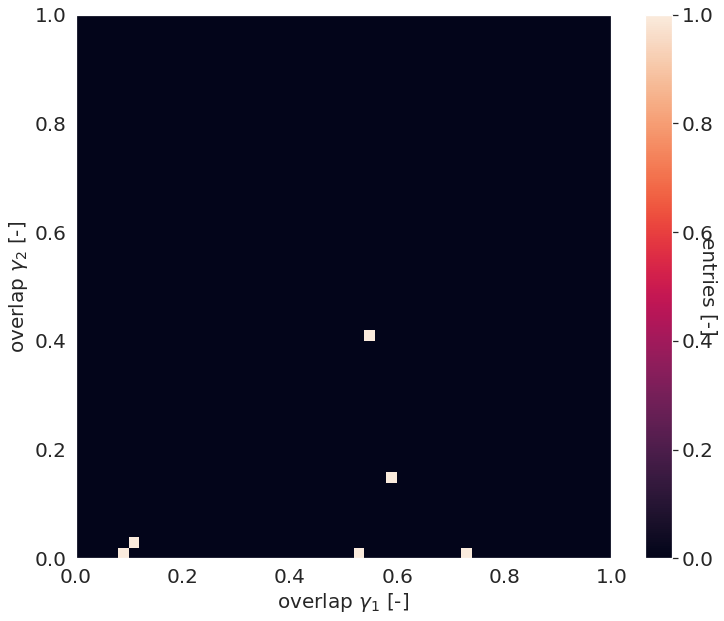

In [13]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 1
y_min    = 0
y_max    = 1
n_bins_x = 50 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 50 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
#print(x_bins)
#print(y_bins)

plt.hist2d(overlaps[0], overlaps[1], bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('overlap $\gamma_1$ [-]', fontsize=20)
plt.ylabel('overlap $\gamma_2$ [-]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

#plt.savefig("NAME.png", bbox_inches='tight')
plt.show()
plt.close()

# Plot Distances (true_gamma_first_step - reco_gamma_start)

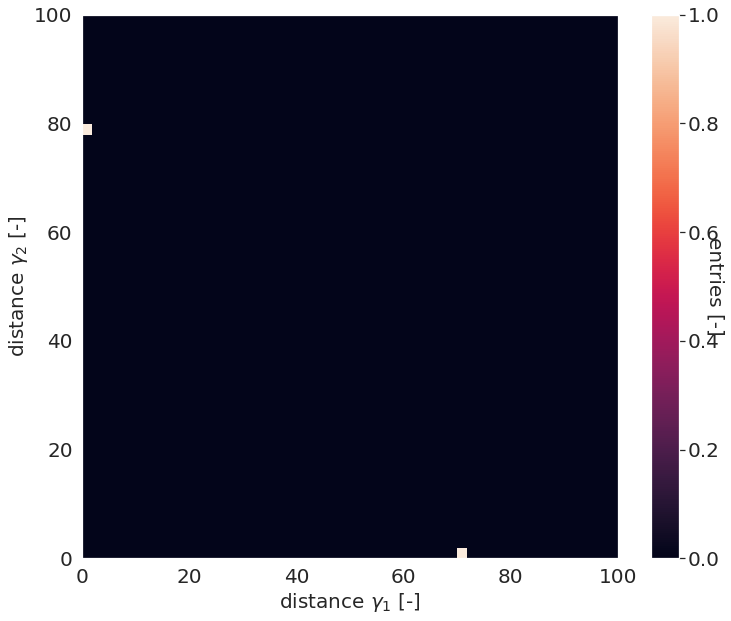

In [14]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 100
y_min    = 0
y_max    = 100
n_bins_x = 50 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 50 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
#print(x_bins)
#print(y_bins)

plt.hist2d(distances[0], distances[1], bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('distance $\gamma_1$ [-]', fontsize=20)
plt.ylabel('distance $\gamma_2$ [-]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

#plt.savefig("NAME.png", bbox_inches='tight')
plt.show()
plt.close()

# Plot Angle (true_gamma_angle vs. reco_gamma_angle)

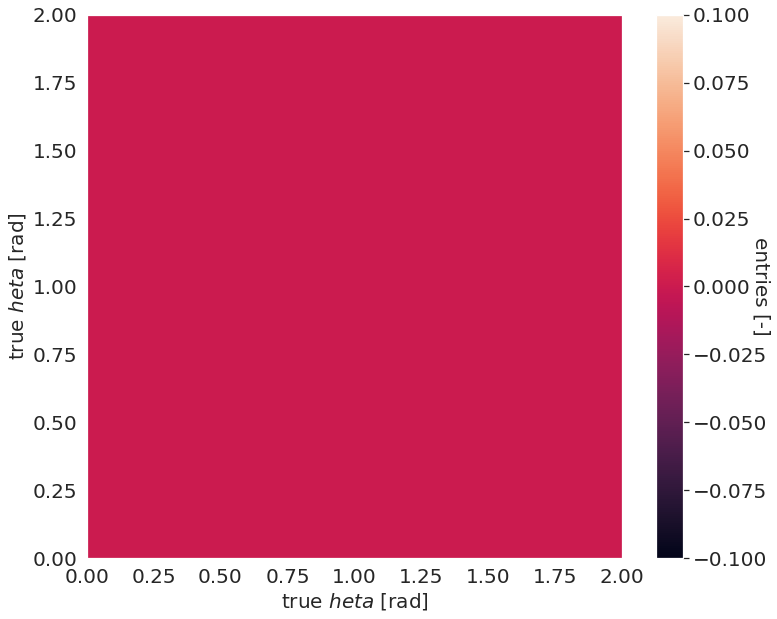

In [15]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 2
y_min    = 0
y_max    = 2
n_bins_x = 50 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 50 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
#print(x_bins)
#print(y_bins)

plt.hist2d(distances[0], distances[1], bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('true $\theta$ [rad]', fontsize=20)
plt.ylabel('true $\theta$ [rad]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

#plt.savefig("NAME.png", bbox_inches='tight')
plt.show()
plt.close()

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.  ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.  ]


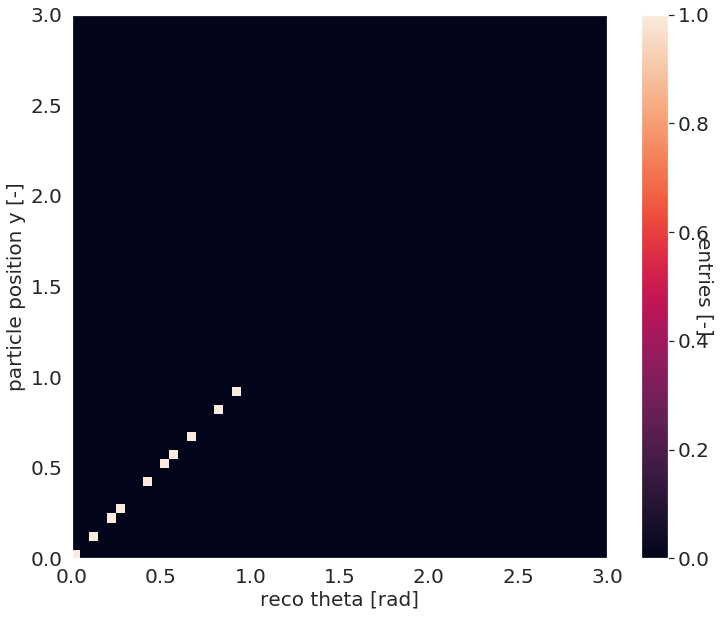

In [16]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 3
y_min    = 0
y_max    = 3
n_bins_x = 60 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 60 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
print(x_bins)
print(y_bins)

#plt.hist2d(x,y,bins=[x_bins,y_bins])

# Data
reco_theta = []
reco_theta2 = []
for i in range(10):
    reco_theta.append(i/10)
    reco_theta2.append(i/10)
#for i, res in enumerate(ResultsList):
#    if res.event_id in selected_events:
#        reco_theta.append(res.reco_gamma_angle)
#        reco_theta2.append(2*res.reco_gamma_angle)
        

plt.hist2d(reco_theta, reco_theta2, bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('reco theta [rad]', fontsize=20)
plt.ylabel('particle position y [-]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

#plt.savefig("NAME.png", bbox_inches='tight')
plt.show()
plt.close()

# Other Plots

<Figure size 1080x720 with 0 Axes>

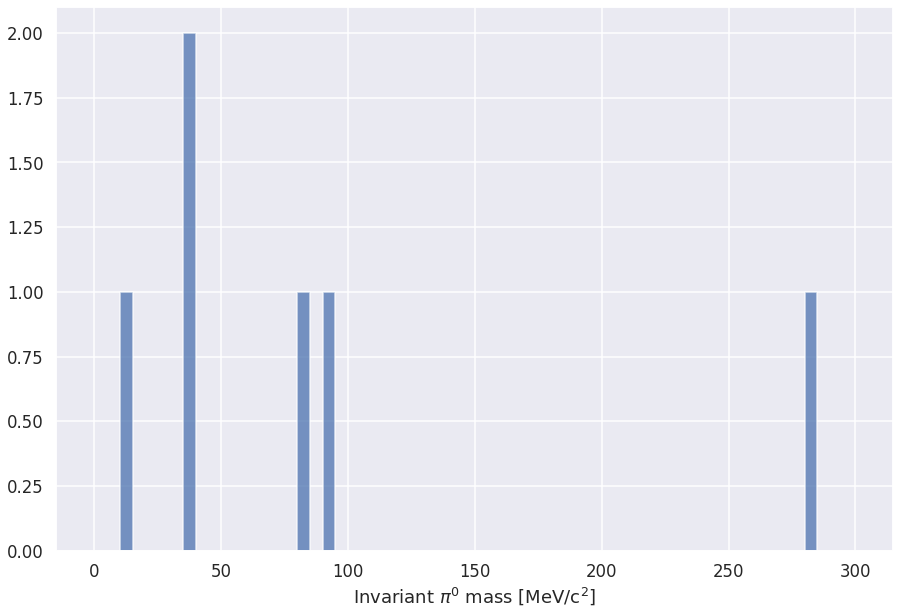

In [17]:
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma

def fit_func(bins, n, func):
    from scipy.optimize import curve_fit
    center = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(func, center, n, p0=(100, 100, 10))
    print(" Fitted parameters: \n a [-]: \t ", popt[0],
          " \n \u03BC [MeV/c2]: \t ", popt[1],
          " \n \u03C3 [MeV/c2]: \t ", popt[2])

    x = np.arange(0, 300, 1)
    y = func(x, popt[0], popt[1], popt[2])
    plt.plot(x, y, label='Fit: mass=%5.3f, width=%5.3f' % (popt[1], popt[2]))
    plt.legend()

# Load the output file, draw mass peak
#df = pd.read_csv(chain_cfg['name']+'_' + str(chain_cfg['fiducialize']) + 'px_' + str(data_size) + 'ev_log.csv')
df = pd.read_csv('masses_fiducialized_' + str(chain_cfg['fiducialize']) + 'px.csv')
plt.figure()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df.pion_mass, bins=60, range=[0,300], alpha=0.75)
ax.set_xlabel('Invariant $\pi^0$ mass [MeV/c$^2$]')

# Fit the peak with a Gaussian
#fit_func(bins, n, gaus)
#fig_name = '06_fiducialized_' + str(chain_cfg['fiducialize']) + 'px_' + str(data_size) + 'ev.png'
fig_name = 'masses_fiducialized_' + str(chain_cfg['fiducialize']) + 'px.png'
plt.savefig(fig_name,dpi=400)
plt.show()

# Print pion mass dataframe
#print(df.to_string())

FileNotFoundError: [Errno 2] File b'if_n_TRUEpi0s_equals_n_MATCHEDpi0s.csv' does not exist: b'if_n_TRUEpi0s_equals_n_MATCHEDpi0s.csv'

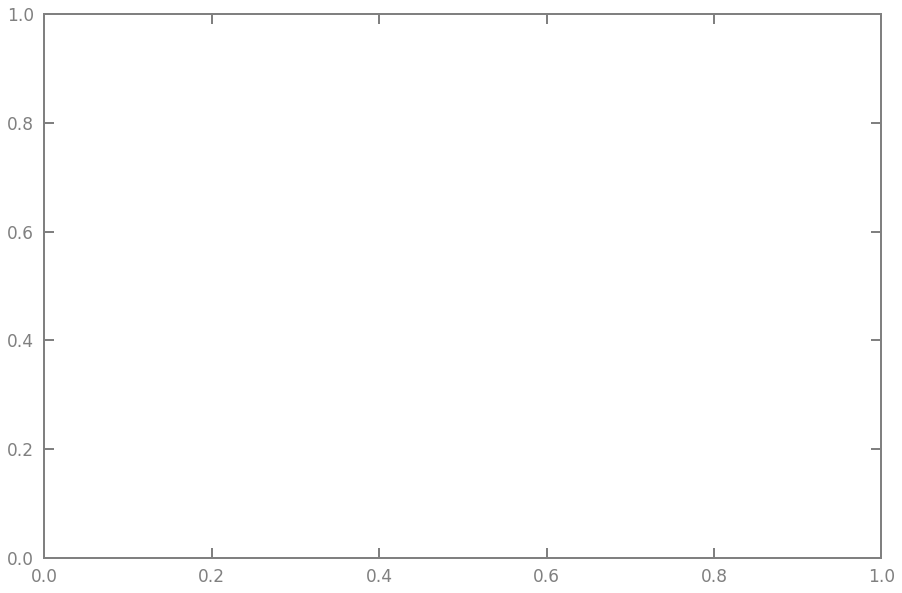

In [18]:
seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper


# Define gauss function
def gaus(x, a, mu, sigma):
    return  a*np.exp(-(x-mu)**2/2./sigma**2)/np.sqrt(2./np.pi)/sigma


# Define fit function
def fit_func(bins, n, func):
    from scipy.optimize import curve_fit
    center = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(func, center, n, p0=(100, 100, 10))
    #print(" Fitted parameters: \n a [-]: \t ", popt[0],
    #      " \n \u03BC [MeV/c2]: \t ", popt[1],
    #      " \n \u03C3 [MeV/c2]: \t ", popt[2])
    print(" Fitted parameters: \n ",
          " \n a     [-]:      \t ", popt[0],
          " \n mu    [MeV/c2]: \t ", popt[1],
          " \n sigma [MeV/c2]: \t ", popt[2])

    #x = np.arange(0, 300, 1)
    #y = func(x, popt[0], popt[1], popt[2])
    #plt.plot(x, y, label='Fit: mass=%5.3f, width=%5.3f' % (popt[1], popt[2]))
    #plt.legend()

    return popt[0], popt[1], popt[2]


# Define histogram range and binning
x_min    = 0
x_max    = 450
n_bins_x = 50
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)


# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Define dataframes
df = pd.read_csv('if_n_TRUEpi0s_equals_n_MATCHEDpi0s.csv')

# Make filtered dataframes
#df_unfiducialized = df
df_fiducialized = df[(df['matched_gamma_1_OOFV'] == 0) & (df['matched_gamma_2_OOFV'] == 0)]
df_fiducialized_plus_Eth35 = df_fiducialized[(df_fiducialized['matched_gamma_1_energy'] > 35) & (df_fiducialized['matched_gamma_2_energy'] > 35)]
df_fiducialized_plus_Eth60 = df_fiducialized[(df_fiducialized['matched_gamma_1_energy'] > 60) & (df_fiducialized['matched_gamma_2_energy'] > 60)]

# Plot dataframes
#n_0, bins_0, patches_0 = plt.hist(df_unfiducialized.matched_pi0_mass, bins=n_bins_x, range=[x_min,x_max], histtype='step', color='r', linewidth=3, alpha=0.8)
n_1, bins_1, patches_1 = plt.hist(df_fiducialized.matched_pi0_mass, bins=n_bins_x, range=[x_min,x_max], histtype='step', color='b', linewidth=3, alpha=0.8)
n_2, bins_2, patches_2 = plt.hist(df_fiducialized_plus_Eth35.matched_pi0_mass, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', color='g', linewidth=3, alpha=0.8)
n_3, bins_3, patches_3 = plt.hist(df_fiducialized_plus_Eth60.matched_pi0_mass, bins=n_bins_x, range=[x_min,x_max], histtype='step', color='orange', linewidth=3, alpha=0.8)

# Fit the peaks with Gaussians
# If you want to draw the fit function: uncomment lines in fit_func
#a_0, mu_0, sigma_0 = fit_func(bins_0, n_0, gaus)
#a_1, mu_1, sigma_1 = fit_func(bins_1, n_1, gaus)


# Legend
#unfiducialized = 'not fiducialized'
fiducialized = 'fiducialized 14 px'
fiducialized_plus_Eth35 = 'fiducialized 14 px, e_th: 35 MeV'
fiducialized_plus_Eth60 = 'fiducialized 14 px, e_th: 60 MeV'
plt.legend([fiducialized, fiducialized_plus_Eth35, fiducialized_plus_Eth60], loc=[0.5,0.8], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('Invariant $\pi^0$ mass [MeV/c$^2$]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)


# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'if_n_TRUEpi0s_equals_n_MATCHEDpi0s.png'
plt.savefig(fig_name, dpi=400)
#plt.show()


In [ ]:
# Dataframe
data_file_name = 'n_pi0s_in_event.csv'
df = pd.read_csv(data_file_name)

# Size
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = -0.5
x_max    = 5.5
y_min    = -0.5
y_max    = 5.5
n_bins_x = 6 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 6 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
print(n_bins_x)
print(x_bins)

#plt.hist2d(x,y,bins=[x_bins,y_bins])

# Data
plt.hist2d(df.true_n_pi0s, df.reco_n_pi0s, bins=[x_bins,y_bins], cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('true n $\pi^0$s [-]', fontsize=20)
plt.ylabel('reconstructed n $\pi^0$s [-]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

plt.savefig("n_pi0s_in_event.png", bbox_inches='tight')
plt.show()
plt.close()

# Just some tests

In [ ]:
# The config files contain, e.g., 'particles', 'cluster_label', etc.

# Get particle:
particle = chain.event['particles'][0][0]
#help(particle)

cluster = chain.event['cluster_label'][0]
print("cluster: ", cluster)
# to see what the entries of this array are, look up the information from the .cfg:
      #cluster_label:
      #  - parse_cluster3d_full
      #  - cluster3d_pcluster
      #  - particle_corrected
# -> Need to have a look to 'parse_cluster3d_full, which lives in mlreco/iotools/parse_cluster3d_full'

In [ ]:
#if not 'output' in self.__dict__:
   #self.output = []

In [ ]:
#clusters = chain.event['cluster_label']
#print(len(clusters))

#for i in range(200):
#    print(clusters[i][:]) # if using 'parse_cluster3d_full', entries are: x, y, z, batch_id, voxel_count, group_id, semantic_type

In [ ]:
chain.output.keys()

In [ ]:
chain.event.keys()

In [ ]:
print(chain.__dict__)

In [ ]:
if 'cfg' in chain.__dict__:
    print(' cfg is dictionary in chain! ')

In [ ]:
chain.output.keys()

In [ ]:
chain.output['showers'][0]

In [ ]:
shower = chain.output['showers'][0]
help(shower)

In [ ]:
particle = 0
help(chain.event['particles'][0][particle].first_step())

In [ ]:
! cat /home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/config_files/uresnet_ppn.cfg

In [ ]:
print(chain.event.keys())
#print(' ---------------------------------------------------------------- ')
#print(chain.output['shower_mask'])
#print(' ---------------------------------------------------------------- ')
#print(chain.output['charge'])
#print(' ---------------------------------------------------------------- ')
#print(chain.event['input_data'])
#print(' ---------------------------------------------------------------- ')
#print(chain.event['dbscan_label'][0])
#print(chain.event['dbscan_label'][1])
#print(chain.event['dbscan_label'][2])
#print(chain.event['dbscan_label'][-1])
#print(' ---------------------------------------------------------------- ')
#print(': ', chain.event['particles'][0][0].n_voxels())
#print(': ', chain.event['particles'][0][0].position().x())
#print(': ', chain.event['particles'][0][0].distance_travel())
#print(': ', chain.event['particles'][0][0].end_position().x())
#print(': ', chain.event['particles'][0][0].first_step().x())
#print(': ', chain.event['particles'][0][0].last_step().x())

print(chain.event['cluster_label'][0])
print(chain.event['cluster_label'][-1])

#help(chain.event['particles'][0][0])
#print(chain.event['particles'][0][0].x())
#dict_keys(['input_data', 'segment_label', 'semantics', 'dbscan_label', 'particles_label', 'cluster_label', 'particles', 'ppn_label', 'index'])

#for p in range(len(chain.event['particles'][0])):
#    particle = chain.event['particles'][0]
#    print(particle[p].t(), ' \t ', particle[p].pdg_code())

In [ ]:
for particle in range(len(chain.event['particles'][0])):
    p = chain.event['particles'][0][particle]
    help(p)
    #print(p.energy_deposit())

In [ ]:
#print(chain.__dict__)

In [ ]:
#print(' Results.__dict__: ', Results.__dict__)

In [ ]:
# All edeps (energies) of the first shower:
print(chain.output['showers'][0].edep)

# The mask for all showers in the event:
# (contains indices, which can be used to get the entries in chain.output['energy'])
mask = chain.output['shower_mask']

# Voxels of the first shower:
# (contains indices, which can be used to get the entries of the shower_shower mask)
voxels = chain.output['showers'][0].voxels

# To finally get the edeps of the first shower, do:
print(chain.output['energy'][mask][voxels])

In [ ]:
# Create CSV file for all true pi0s in the event
#from mlreco.utils import CSVData
#log_path_true_pi0 = 'true_pi0s.csv'
#log_true_pi0 = CSVData(log_path_true_pi0)

# Create CSV file for all reconstructed showers in the event
#from mlreco.utils import CSVData
#log_path_reco_gamma = 'reco_gammas.csv'
#log_reco_gamma = CSVData(log_path_reco_gamma)

In [ ]:
# Rename .csv file with masses in order to keep track of parameters
#name_old = chain_cfg['name']+'_log.csv'
#name_new = chain_cfg['name']+'_' + str(chain_cfg['fiducialize']) + 'px_' + str(data_size) + 'ev_log.csv'
#! mv $name_old $name_new

In [ ]:
#for i, res in enumerate(ResultsList):
#    print(' i: \t ', i, ' \t true n pi0s: \t ', res.true_n_pi0s)

In [ ]:
# Simplest way to run the full chain
# chain = Pi0Chain(io_cfg, chain_cfg)
# chain.run()